In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../input/nlp-getting-started/train.csv')

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


31

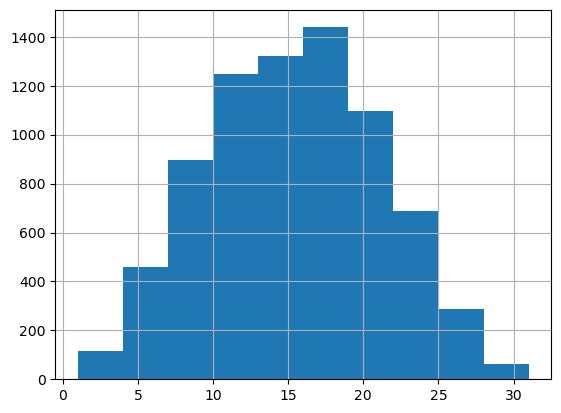

In [5]:
x = df.text.apply(str.split).apply(len)
x.hist()
plt.show
x.max()

In [6]:
#X_train = df.text.apply(lambda x:"".join(ch.lower() for ch in x if ch.isalnum() or ch == " "))

In [7]:
stop_words = [ 'stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'i', 'that', 'had', 'on', 'for', 'were', 'was', 'of', 'as', 'are'] # mostly from NLTK
df.text = df.text.str.lower()
df.text = df.text.apply(lambda x: " ".join(word for word in x.split(" ") if word not in stop_words))

In [8]:
df.text.head()

0    our deeds reason this #earthquake may allah fo...
1               forest fire near la ronge sask. canada
2    all residents asked 'shelter place' being noti...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska smo...
Name: text, dtype: object

In [9]:
train = df.sample(frac=0.8, replace=False, random_state=42)
df.index.drop(train.index)
test = df.loc[df.index.drop(train.index)]
train.shape, test.shape

((6090, 5), (1523, 5))

In [10]:
X_train = train.text.values.flatten()
y_train = train.target.values.flatten()
X_test = test.text.values.flatten()
y_test = test.target.values.flatten()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6090,), (6090,), (1523,), (1523,))

In [11]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
tokens = 1000
encoder=TextVectorization(max_tokens=tokens, 
                          standardize='lower_and_strip_punctuation',
                          split='whitespace',
                          ngrams=2,
                          output_mode='int')
encoder.adapt(X_train)
callback=EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True, start_from_epoch=5)

In [13]:
encoder.get_vocabulary()[:10]

['', '[UNK]', 'you', 'my', 'with', 'at', 'by', 'this', 'from', 'be']

In [14]:
model = Sequential([
    encoder,
    Embedding(input_dim=tokens, mask_zero=True, output_dim = 30),
    LSTM(30, return_sequences=False),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 30)          30000     
                                                                 
 lstm (LSTM)                 (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 20)                620       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                        

In [15]:
history = model.fit(X_train, 
          y_train,
          batch_size=32,
          validation_data = (X_test, y_test),
          epochs=15,
          callbacks=[callback])

Epoch 1/15
191/191 [==============================] - 9s 27ms/step - loss: 0.6865 - accuracy: 0.5703 - val_loss: 0.6838 - val_accuracy: 0.5706
Epoch 2/15
191/191 [==============================] - 4s 21ms/step - loss: 0.6824 - accuracy: 0.5745 - val_loss: 0.6802 - val_accuracy: 0.5877
Epoch 3/15
191/191 [==============================] - 4s 21ms/step - loss: 0.6214 - accuracy: 0.6806 - val_loss: 0.5443 - val_accuracy: 0.7538
Epoch 4/15
191/191 [==============================] - 4s 21ms/step - loss: 0.4914 - accuracy: 0.7957 - val_loss: 0.5238 - val_accuracy: 0.7669
Epoch 5/15
191/191 [==============================] - 4s 21ms/step - loss: 0.4609 - accuracy: 0.8154 - val_loss: 0.5278 - val_accuracy: 0.7649
Epoch 6/15
191/191 [==============================] - 4s 21ms/step - loss: 0.4435 - accuracy: 0.8204 - val_loss: 0.5149 - val_accuracy: 0.7754
Epoch 7/15
191/191 [==============================] - 4s 21ms/step - loss: 0.4298 - accuracy: 0.8287 - val_loss: 0.5105 - val_accuracy: 0.7748

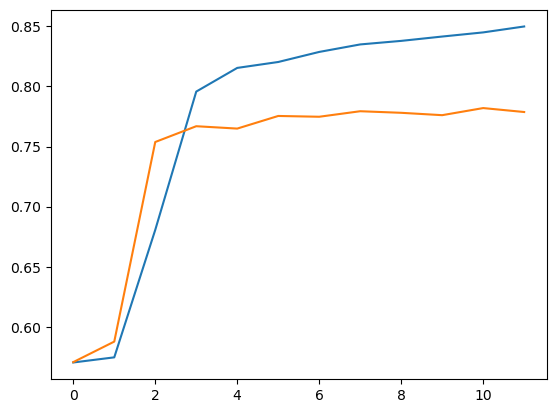

In [16]:
n = len(history.history['accuracy'])
plt.plot(range(n), history.history['accuracy'])
plt.plot(range(n), history.history['val_accuracy'])
plt.show()

In [17]:
best_model = history.model

In [18]:
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')
test_df.text = df.text.str.lower()
test_df.text = test_df.text.apply(lambda x: " ".join(word for word in x.split(" ") if word not in stop_words))
test = test_df.text.values.flatten()
test_df.shape, test.shape

((3263, 4), (3263,))

In [19]:
yhat = best_model.predict(test)

102/102 [==============================] - 2s 6ms/step


In [20]:
submission = test_df[['id']].copy()
submission['target'] = np.round(yhat,0)
submission.target = submission.target.astype(int)
submission.to_csv('submission.csv', index=False)

In [21]:
pd.read_csv('submission.csv').head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,0
